# An Introduction to Expected Shortfall

## What is Expected Shortfall?
Expected shortfall (ES), also known as Conditional Value-at-Risk (CVaR), is yet another quantile based risk metric widely used in quantitative finance. ES extends VaR to tell an investor more about their "tail risk." That is to say, it gives them more information about potential large losses. VaR answers the question "what is the <b>minimum</b> amount I will lose on the x% worst trading days?" ES extends this to answer, "what is the <b>average</b> amount I will lose on the x% worst trading days?"

So clearly, the motivation behind ES is to understand more about large losses and the risk profile of any given portfolio.

## Advantage Over VaR

The main advantage of ES over VaR stems from the fact that ES conforms to the properties of what is known as a <b>coherent</b> risk measure. For a measure to be considered coherent, there are some mathematical properties that must hold true for it. If you are interested to see exactly how ES conforms to the properties of a coherent risk measure, please take a look at [this wiki page](https://en.wikipedia.org/wiki/Coherent_risk_measure). For now, it is important to note that VaR is not coherent because it does not obey the notion of sub-additivity. Namely, the VaR of a portfolio's holdings is not necessarily equal to the VaR of the entire portfolio.

On the other hand, ES is sub-additive and conforms to the other necessary criteria. This means that it can be used to do things like [specify capital requirements for banks](https://en.wikipedia.org/wiki/Basel_Accords), and inform portfolio opimization techniques. Also, the direct interpretation of ES is a lot more useful to an investor.

The illustration below offers a good visual representation of ES and how it compares to VaR. What you are seeing is the loss distribution of a portfolio. Losses increase as you go right along the x-axis. The right tail is what we are concerned with.

<img src='./esill.jpg' alt='expected shortfall illustration' width=500>

## Mathematical Definition
Let $X$ be a random variable on the loss distribution of a portfolio. Expected shortfall is defined as:

$\textrm{ES}_\alpha(X)=\textrm{E}[X | X \geq \textrm{VaR}_\alpha(X) ]$ 

given that:

$\textrm{VaR}_\alpha(X)=\textrm{min}\{z | F_X(z) \geq \alpha\}$

Note: $\alpha \in (0,1)$

ES can be read as the expected value of the random variable $X$ when the VaR for that $\alpha$ is met. If you look online, you will see many more definitions of ES and VaR. I just prefer these as they are agnostic towards assuming any specific return (or loss) distribution of a portfolio.

## Putting ES to Use Through Code

To make ES usefull to us, we will need to put it into code. Below I do exactly that. The exact procedure is as follows:
1. Create a portfolio
2. Calculate and show the loss distribution of the portfolio
3. Find the VaR at the level of alpha we choose (95% and 99%)
4. Find the ES corresponding to the different values of alpha
5. Display and compare results

The method that I will employ here is the historical method. This assumes no specific distribution for the portfolio's returns. This has the advantage of not introducing modelling error when choosing an arbitrary return distribution. The major caveat to employing this method is that it is not entirely accurate when the return distribution is likely to change over time (which it most likely will). Different investors will have their own ways to model a portfolio's returns and thus calculate VaR and ES. I will definitely share more methods at a later time.

With the historical method, we are going to use two years worth of data. Why? Again, this is a just a choice. Too much data and you are going to encorporate data that may not be relevant to the portfolio today. Too little, and the metrics will offer little insight. Two years seems like a decent enough balance, though it is not a sophisticated choice. The goal here is simply to demonstrate what ES is and how it can be used in practice.

### Constructing the Portfolio

We will assume our hypothetical portfolio has:
- 3 shares of GOOG
- 20 shares of AAPL
- 15 shares of MSFT

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import yfinance as yf

In [121]:
# defining tickers to gather data on, yfinance takes a string of tickers
tickers = "GOOG AAPL MSFT"
shares_goog = 3
shares_aapl = 20
shares_msft = 15

# using yfinance to fetch price data, choosing a period of 2 years
data = yf.download(tickers=tickers, period="2y")

# selecting just adjusted close data
df = data['Adj Close']

# creating portfolio column
df['Portfolio'] = ((df['AAPL'] * shares_aapl) +
                   (df['GOOG'] * shares_goog) +
                   (df['MSFT'] * shares_msft))

# calculating logarithmic returns
df['log_ret'] = np.log(df['Portfolio']) - np.log(df['Portfolio'].shift(1))
df.dropna(subset=['log_ret'], inplace=True)

df.tail()

[*********************100%***********************]  3 of 3 completed


,AAPL,GOOG,MSFT,Portfolio,log_ret
Date,,,,,
2021-06-16,130.149994,2513.929932,257.380005,14005.489746,-0.001761
2021-06-17,131.789993,2527.419922,260.899994,14131.559540,0.008961
2021-06-18,130.460007,2511.350098,259.429993,14034.700317,-0.006878
2021-06-21,132.300003,2529.100098,262.630005,14172.750427,0.009788
2021-06-22,133.979996,2539.989990,265.510010,14282.220032,0.007694


### The Loss Distribution

Here we show a histogram of the logarithmic returns we calculated previously. Again, we are trying to focus on the right tail of this distribution with ES and VaR.

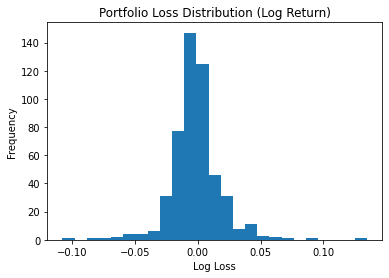

In [73]:
log_losses = -1*(df['log_ret'].to_numpy())

plt.hist(log_losses, bins=25)
plt.xlabel('Log Loss')
plt.ylabel('Frequency')
plt.title('Portfolio Loss Distribution (Log Return)')
plt.show()


### Finding VaR

We can use the built-in quantile function in numpy in order to conveniently find values for VaR. By default, numpy interpolates the value linearly.

In [95]:
# sorting array of log returns and multiplying by -1 to get losses
sorted_log_returns = -1*np.sort(df['log_ret'].to_numpy())

var_95_log = np.quantile(sorted_log_returns, 0.95)
var_99_log = np.quantile(sorted_log_returns, 0.99)

# converting to dollar amount
last_port_value = df['Portfolio'].tail(1).iloc[0]

var_95 = round(last_port_value * var_95_log, 2)
var_99 = round(last_port_value * var_99_log, 2)

print(f'The VaR at alpha 95% and 99% is ${var_95} and ${var_99}, respectively.')

The VaR at alpha 95% and 99% is $407.69 and $750.01, respectively.


### Finding ES

To find ES, all we have to do is find the returns that are at least as great as the value for VaR. Then, we average over these returns.

<b>Note</b>: by the definition of ES, we should witness about $(1-\alpha)\times N$ returns that meet or exceed VaR for any level of alpha. Here, $N$ represents the number of days we used in our calculation. We will verify this below.

In [117]:
# finding where VaR is met and exceeded
es_95_df = df[(-1*df['log_ret']) >= var_95_log]
es_99_df = df[(-1*df['log_ret']) >= var_99_log]

# averaging over the necessary returns
es_95 = round(-1*es_95_df['log_ret'].mean()*last_port_value, 2)
es_99 = round(-1*es_99_df['log_ret'].mean()*last_port_value, 2)

print(f'The VaR at alpha 95% and 99% is ${es_95} and ${es_99}, respectively.')

The VaR at alpha 95% and 99% is $691.79 and $1134.75, respectively.


In [118]:
print(f'There are {len(es_95_df)} and {len(es_99_df)} returns used for our calculation of ES at alpha 95% and 99%, respectively.')

There are 26 and 6 returns used for our calculation of ES at alpha 95% and 99%, respectively.


### Comparing Results

In [120]:
data_dict = {'Loss': {'95% VaR': f'${var_95}', '95% ES': f'${es_95}',
                         '99% VaR': f'${var_99}', '99% ES': f'${es_99}'}
            }

res_df = pd.DataFrame.from_dict(data_dict, orient='index')
res_df

,95% VaR,95% ES,99% VaR,99% ES
Loss,$407.69,$691.79,$750.01,$1134.75


Looking at the results, there are a couple more important observations to be made. First of all, we see that in both cases ES is larger than VaR. This is another fact that follows from the definition of ES. If we found VaR to have a value that exceeded ES, then we know we did something wrong. Lastly, at higher levels of alpha, we obtain higher values for VaR and ES. This is a direct result from the quantile we choose and how it aligns with the loss distribution. The higher the value for alpha, the higher the values for VaR and ES. With most distributions, we should witness the values for VaR and ES increasing non-linearly as we increase alpha.

## Conclusion and Next Steps

To summarize, we first explained what expected shortfall is and how it extends value-at-risk. We then took a look at its mathematical definition and why it is considered a coherent risk measure. We then learned why it is useful to investors and risk managers. The rest of the notebook is dedicated towards how it can be used in practice.

To extend these ideas, I would advise you to look into how one may better model a portfolio's return distribution. You can use tools like Gaussian copulas or empirical CDFs.